In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class - Conditioning Tasks

In [2]:
class Drosophila_RNN(nn.Module):
    def __init__(self, KC_size=200, MBON_size=20, DAN_size=20, FBN_size=60, ext_size=2, out_size=1, net_seed=1234):
        super(Drosophila_RNN, self).__init__()
        # Set the seeds
        self.n_seed = net_seed
#         np.random.seed(net_seed)
#         torch.manual_seed(net_seed)
        # Set constants
        W_KC_MBON_max = 0.05
        self.KC_MBON_min = 0. # Minimum synaptic weight
        self.KC_MBON_max = W_KC_MBON_max # Maximum synaptic weight
        self.W_KC_MBON = Variable(torch.rand((MBON_size, KC_size)) * W_KC_MBON_max, requires_grad=False)
        self.tau_w = 5 # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1 # Time scale of output circuitry activity
        # Set the sizes of layers
        self.N_KC = KC_size
        self.N_MBON = MBON_size
        self.N_FBN = FBN_size
        self.N_DAN = DAN_size
        self.N_recur = MBON_size + FBN_size + DAN_size
        self.N_ext = ext_size
        self.N_out = out_size
        # Define updatable network parameters
#         seed_num = net_seed
        seed_num = None
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_MBON = torch.zeros((self.N_recur, MBON_size))
        mean_FBN = torch.zeros((self.N_recur, FBN_size))
        mean_DAN = torch.zeros((self.N_recur, DAN_size))
        W_MBON = torch.normal(mean_MBON, torch.sqrt(1 / (sqrt2 * MBON_size)), generator=seed_num)
        W_FBN = torch.normal(mean_FBN, torch.sqrt(1 / (sqrt2 * FBN_size)), generator=seed_num)
        W_DAN = torch.normal(mean_DAN, torch.sqrt(1 / (sqrt2 * DAN_size)), generator=seed_num)
        self.W_recur = nn.Parameter(torch.cat((W_MBON, W_FBN, W_DAN), dim=1), requires_grad=True)
        self.W_ext = nn.Parameter(torch.randn(FBN_size, ext_size), requires_grad=True)
        mean_readout = torch.zeros((out_size, MBON_size))
        std_readout = 1 / torch.sqrt(torch.tensor(MBON_size, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout, generator=seed_num), requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.N_recur) * 0.1, requires_grad=True)
        
    def forward(self, r_KC, r_ext, time, batch_size=30):
        """ Defines the forward pass of the RNN
        
        Synaptic weights from the Keyon cells to the mushroom body output neurons (MBONs)
        are fixed for each trial. All other weights are network parameters.
        
        The KC->MBON weights are set within the range [0, 0.05].
        MBONs receive external input from Keyon cells (r_KC i.e. 'odors').
        Feedback neurons (FBNs) receive external contextual input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero. DANs receive no external input.

        Inputs
            r_KC = activity of the Kenyon cell neurons (representing odors)
            r_ext = context signals (representing the conditioning context)
            time = time vector for a single interval
            W0 = initial weights for KC->MBON connections
            batch_size = number of trials in batch

        Returns
            r_recur: list of torch.ndarray(batch_size, N_MBON + N_FBN + N_DAN)
                = time series of activities in the output circuitry
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (represents behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        r_init = torch.ones((batch_size, self.N_recur)) * 0.1
        r_init[:, :self.N_MBON] = 0
        r_recur = [r_init]
#         r_recur.append(r_init)

        # Initialize KC->MBON weights
        readout = [torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON]).squeeze()]
#         readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON])))

        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        W_recur[:self.N_MBON, -self.N_DAN:] = 0

        # Update activity for each time step
        for t in range(time.size()[0] - 1):
            # Define the input to the output circuitry
            I_KC_MBON = torch.einsum('bmk, bk -> bm', self.W_KC_MBON.repeat(batch_size, 1, 1), r_KC[:, :, t])
            I_FBN = torch.einsum('bfe, be -> bf', self.W_ext.repeat(batch_size, 1, 1), r_ext[:, :, t])
            I = torch.zeros((batch_size, self.N_recur))
            I[:, :self.N_MBON] = I_KC_MBON
            I[:, self.N_MBON:self.N_MBON + self.N_FBN] = I_FBN

            # Update the output circuitry activity
            Wr_prod = torch.einsum('bsr, br -> bs', W_recur.repeat(batch_size, 1, 1), r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(batch_size, 1) + I)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Calculate the readout
            readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON])))

        return r_recur, readout
            
        
# Clipping weights between [0, 0.05]
# https://discuss.pytorch.org/t/how-to-do-constrained-optimization-in-pytorch/60122
# https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620
# https://discuss.pytorch.org/t/restrict-range-of-variable-during-gradient-descent/1933/4

# Setting DAN->MBON weights to zero
# https://pytorch.org/docs/stable/generated/torch.triu.html

# Broadcasting using einsum
# https://github.com/pytorch/pytorch/issues/15671


In [3]:
# Define the cost function for conditioning tasks
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.
    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eq. (3) and (9) in Jiang 2020.
    
    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant
    
    Returns
        loss_tot = scalar loss used in backprop
    """
    
    # Set the baseline DAN activity
    DAN_baseline = 0.1
    
    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt)**2, dim=1)
    v_loss = torch.mean(v_sum)
    
    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - 0.1)**2, dim=1)
    r_loss = lam * torch.mean(r_sum, dim=1)
    
    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss
    
    # Average the loss over all batches
    loss_tot = torch.mean(loss)
    
    return loss_tot


In [14]:
# Define a training function for first-order conditioning
def train_net(network, T_int=40, T_stim=2, dt=0.5, n_epochs=2000, n_batch=30, n_odors=10, clip=0.0001, train=True, plot=None):
    """ Trains a network on classical conditioning tasks.
    
    Tasks include first-order or second-order conditioning, or extinction. Tasks consist of
    a single intervals, and since there is no plasticity, activites are not reset between
    consecutive stimulus presentations (network relies on persistent activity to represent
    associations). Each task has its own input generating function. Stimuli are presented
    between 5-15s and 20-30s respectively.
    
    Parameters
        network = RNN network to be trained or ran
        task = type of conditioning task to be trained ('first-order', 'all_tasks')
        T_int = length of task intervals (eg conditioning, test, extinction)
        T_stim = length of time each stimulus is presented
        dt = time step of simulations
        n_epochs = number of epochs to train over
        n_batch = number of trials in mini-batch
        p_ctrl = the fraction of trials that are control (to prevent over-fitting)
        clip = maximum gradient allowed during training
        train = boolean indicating whether to perform backprop
        plot = type of task to run (for plotting purposes)
        
    Returns
        r_out_epoch = output circuit neuron activities for final epoch
        vt_epoch = readout (i.e. valence) for final epoch
        vt_opt = target valence for final epoch
        loss_hist = list of losses for all epochs
        ls_stims = list of stimulus time series
    """
    
    # Present the stimulus between 5-15s and 20-30s of the interval
    stim_min1 = 5
    stim_max1 = 15 - T_stim
    stim_range1 = int((stim_max1 - stim_min1) / dt)
    stim_offset1 = int(stim_min1 / dt)
    stim_min2 = 20
    stim_max2 = 30 - T_stim
    stim_range2 = int((stim_max2 - stim_min2) / dt)
    stim_offset2 = int(stim_min2 / dt)
    # Length of stimulus in indices
    stim_len = int(T_stim / dt)
    # Interval time vector
    time_int = torch.arange(0, T_int + dt/10, dt)

    # Neuron population sizes
    n_KC = network.N_KC
    n_ext = network.N_ext
    n_MBON = network.N_MBON
    # Max KC->MBON weight values
    W_KC_MBON_max = network.KC_MBON_max
    
    # Define a set of 10 odors (CS)
    n_ones = int(n_KC * 0.1)
    odor_list = torch.zeros(n_odors, n_KC)
    gen = torch.Generator()
    gen = gen.manual_seed(network.n_seed)
    odor_inds = torch.multinomial(torch.ones(n_odors, n_KC), n_ones, generator=gen)
    neut_inds = torch.multinomial(torch.ones(n_KC), n_ones, generator=gen)
    neut_odor = torch.zeros(n_KC)
    neut_odor[neut_inds] = 1
    for n in range(n_odors):
        # Define an odor (CS)
        odor_list[n, odor_inds[n, :]] = 1

    # List to store losses
    loss_hist = []

    for epoch in range(n_epochs):
        # Lists to store activities, weights, readouts and target valences
        r_outs = []
        vts = []
#         vals = []

        # Randomly determine the time of each stimulus presentation
        stim_times1 = torch.multinomial(torch.ones(stim_range1), n_batch, replacement=True) + stim_offset1
        stim_times2 = torch.multinomial(torch.ones(stim_range2), n_batch, replacement=True) + stim_offset2
        stim_times = torch.stack((stim_times1.view(-1, 1), stim_times2.view(-1, 1)), dim=1)
        
        # Generate the odor (r_KC) and context (r_ext) inputs, and target valence (vt_opt)
        r_KC, r_ext, vt_opt, ls_stims = first_order_inputs(stim_times, stim_len, time_int.size()[0], odor_list, n_KC, n_ext, n_batch, plot)

        # Run the forward model
        r_int, vt = network(r_KC, r_ext, time_int, n_batch)

        # Append the interval outputs to lists
        r_outs += r_int
        vts += vt

        # Concatenate the activities, weights and valences
        r_out_epoch = torch.stack(r_outs, dim=-1)
        vt_epoch = torch.stack(vts, dim=-1)

        # Calculate the loss
        loss = cond_loss(vt_epoch, vt_opt, r_out_epoch[:, -network.N_DAN:, :])

        if train:
            # Update the network parameters
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
            optimizer.step()

        # Print an update
        if epoch % 500 == 0:
            print(epoch, loss.item())
        loss_hist.append(loss.item())

    return r_out_epoch, vt_epoch, vt_opt, loss_hist, ls_stims

# https://discuss.pytorch.org/t/proper-way-to-do-gradient-clipping/191/13
# https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48
# https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961


In [5]:
# Define functions for each of the conditioning tasks
# Some detail provided in Jiang 2020 -> Methods -> Networks without dopamine-gated plasticity
def first_order_inputs(stim_times, stim_len, time_len, odor_list, n_KC, n_ext, n_batch, plot=None, p_omit=0.3):
    """ Generates inputs for first-order conditioning tasks.
    
    All trials are either CS+, CS- (US omitted) or CS omitted (control trials to avoid over-fitting).
    Of the trials where CS or US is omitted, a second parameter determines the relative fractions of
    CS or US trials omitted (p_omit_CS). See Figure 2 of Jiang 2020 to determine sequencing of stimuli
    during training. To account for the sequential nature of numerical simulations, the target valence
    is set to begin one time step after stimulus onset.
    
    All trials are CS+ or control trials where CS+ is switched out for a neutral CS in the second
    presentation. In the case where the CS is switched, the target valence is zero. To account for the
    sequential nature of numerical simulations, the target valence is set to begin one time step after
    stimulus onset.
    
    The mix of conditions is listed as follows:
        probability of trials where CS+ is switched = 0.5
    
    Parameters
        stim_times = randomly selected indices of stimulus presentations for each interval
        stim_len = length of stimulus presentation (in indices)
        time_len = size of time vector
        odor_list = list of 10 odors used for all training
        n_KC = number of Kenyon cell input neurons
        n_ext = number of contextual input neurons
        n_batch = number of trials in mini-batch
        plot = used when plot function is called, indicates which task to plot
        p_omit = probability of omitting either CS or US from trials
        
    Returns
        r_KCt = odor (KC) input time series array for trial
        r_extt = context (ext) input time series array for trial
        vt_opt = time series of target valence for plotting and loss calculations
        ls_stims = list of stimulus time series for plotting
    """
    
    # Conditioned stimuli (CS) = odors
    odor_inds = torch.multinomial(torch.ones(odor_list.shape[0]), n_batch, replacement=True)
    r_KC = torch.zeros(n_batch, n_KC)
    for b in range(n_batch):
        # Define an odor (CS) for each trial
        r_KC[b, :] = odor_list[odor_inds[b], :]
    # Unconditioned stimuli (US) = context
    r_ext = torch.multinomial(torch.ones(n_batch, n_ext), n_ext)
    
    # Determine whether CS2+ is switched (switch on half of trials)
    switch_inds = torch.rand(n_batch) < 0.5

    # Initialize activity matrices
    r_KCt = torch.zeros(n_batch, n_KC, time_len)
    r_extt = torch.zeros(n_batch, n_ext, time_len)
    time_CS_both = torch.zeros(n_batch, time_len)
    time_US_both = torch.zeros_like(time_CS_both)
    vt_opt = torch.zeros_like(time_CS_both)
    
    # For each stimulus presentation
    n_ints = 2
    for i in range(n_ints):
        # Initialize time matrices
        time_CS = torch.zeros(n_batch, time_len)
        time_US = torch.zeros(n_batch, time_len)
        
        for b in range(n_batch):
            stim_inds = stim_times[b, i] + torch.arange(stim_len)
            # Set the CS time
            time_CS[b, stim_inds] = 1
            # Set the US time
            if i == 0:
                time_US[b, stim_inds + stim_len] = 1
            # Set the CS+/CS2 and target valence times
            if i == 1:
                # In half the trials, switch the odor (target valence is zero)
                if (plot is None and switch_inds[b]) or plot == 'CS2':
#                     CS2_inds = torch.multinomial(torch.ones(n_KC), int(n_KC * 0.1))
#                     r_KC[b, CS2_inds] = 1
                    CS2_inds = torch.multinomial(torch.ones(n_KC), n_KC)
                    r_KC[b, :] = r_KC[b, CS2_inds]
                    r_ext[b, :] = 0
                # If the odor is not switched, set the target valence
                else:
                    if r_ext[b, 0] == 1:
                        vt_opt[b, (stim_inds + 1)] = 1
                    elif r_ext[b, 1] == 1:
                        vt_opt[b, (stim_inds + 1)] = -1
                        
        # Calculate the stimulus time series (KC = CS, ext = US)
        r_KCt += torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(n_KC, 1, 1))
        r_extt += torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
        time_CS_both += time_CS
        time_US_both += time_US

    # Make a list of stimulus times to plot
    ls_stims = [time_CS_both, time_US_both]

    return r_KCt, r_extt, vt_opt, ls_stims
    

In [6]:
# def print_trial(network, task1:str, task2:str, dt=0.5):
def print_trial(network, task, n_odors=10, dt=0.5):
    """ Plots a figure similar to Figure 2 from Jiang 2020.
    
    Runs the network using a novel combination of conditioned and unconditioned stimuli,
    then prints the results. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen mushroom body
    output neurons (MBONs).
    
    Paramters
        network = previously trained RNN
        task = the type of task to be plotted ('CS+' or 'CS2')
        dt = time step of the simulation/plot
    """
    
    # Set the labels for the plots
    if task == 'CS+':
        task_title = 'First-Order Conditioning'
    elif task == 'CS2':
        task_title = 'CS+ Generalization'
    
    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Run the network
    r_out, vt, vt_opt, loss_hist, stim_ls = train_net(network, dt=dt, n_epochs=1, n_batch=1, n_odors=n_odors, train=False, plot=task)
    r_out = r_out.detach().numpy().squeeze()
    vt = vt.detach().numpy().squeeze()
    vt_opt = vt_opt.detach().numpy().squeeze()
    plot_CS = stim_ls[0].numpy().squeeze()
    plot_US = stim_ls[1].numpy().squeeze()
    plot_time = np.arange(plot_CS.size) * dt

    # Plot the conditioning and test
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    # Second-order conditioning involves an additional stimulus time series
    if task == 'CS+':
        ax1.plot(plot_time, plot_CS, label=task)
    else:
        half_ind = plot_time.size // 2
        plot_CSp = np.zeros(plot_time.size)
        plot_CSp[:half_ind] = plot_CS[:half_ind]
        plot_CS2 = np.zeros(plot_time.size)
        plot_CS2[half_ind:] = plot_CS[half_ind:]
        ax1.plot(plot_time, plot_CSp, label='CS+')
        ax1.plot(plot_time, plot_CS2, label=task)
    ax1.plot(plot_time, plot_US, label='US')
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title(task_title, fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.N_MBON, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout();
    

In [7]:
# Initialize the network
classic_net = Drosophila_RNN()
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.N_DAN)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([60, 2])
torch.Size([1, 20])
torch.Size([100])


In [8]:
train_bool = True
n_od = 1
if train_bool:
#     r_out, vt, vt_opt, loss_hist, _ = train_net(classic_net, n_epochs=2000, n_odors=10)
    r_out, vt, vt_opt, loss_hist, _ = train_net(classic_net, n_epochs=5000, n_odors=n_od)


0 1.9309476613998413
500 0.010518250055611134
1000 0.006455826107412577
1500 0.004660421051084995
2000 0.003978092223405838
2500 0.0036446084268391132
3000 0.003256340743973851
3500 0.0028702670242637396
4000 0.0028067631646990776
4500 0.0026699802838265896


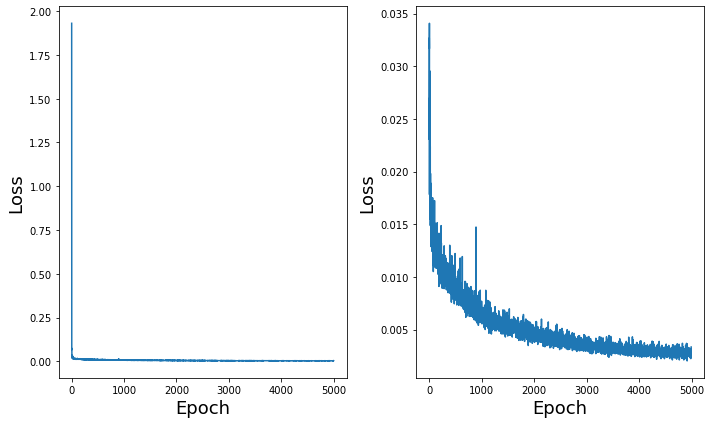

In [9]:
if train_bool:
    # Plot the loss function
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(loss_hist)
    axes[0].set_xlabel('Epoch', fontsize=label_font)
    axes[0].set_ylabel('Loss', fontsize=label_font)
    axes[1].plot(loss_hist[5:])
    axes[1].set_xlabel('Epoch', fontsize=label_font)
    axes[1].set_ylabel('Loss', fontsize=label_font)
    fig.tight_layout();


In [10]:
# torch.save(classic_net.state_dict(), 'trained_N5_no_plasticity_10odors_2000epochs.pt')
# torch.save(classic_net.state_dict(), 'trained_N6_no_plasticity_1odors_2000epochs.pt')

# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://pytorch.org/tutorials/beginner/saving_loading_models.html


1
tensor([[ 46,  15,  94,  83,  78,  54,  39,  48,  56, 182, 162,   7, 147, 124,
          57,  69,  65,  38, 152, 132]])
0 0.0016875865403562784
1
tensor([[ 46,  15,  94,  83,  78,  54,  39,  48,  56, 182, 162,   7, 147, 124,
          57,  69,  65,  38, 152, 132]])
0 0.003871388267725706


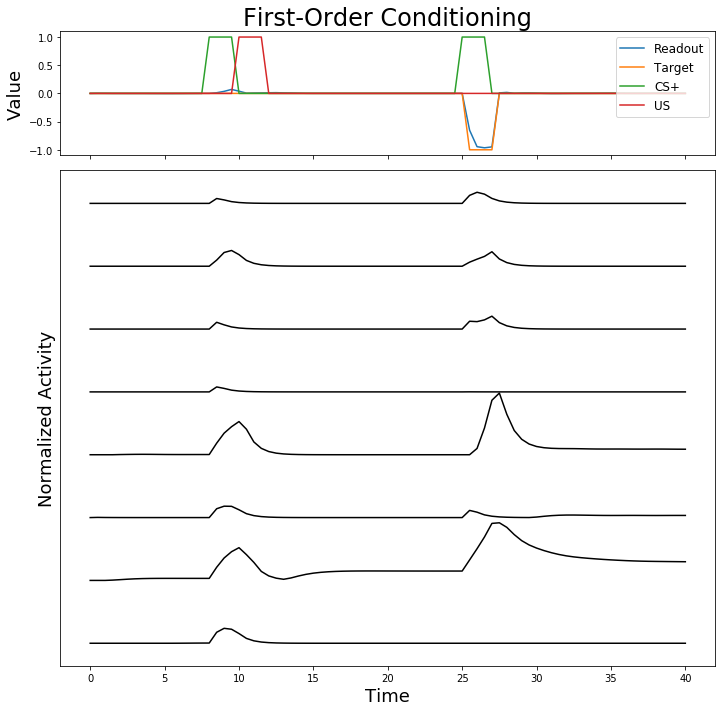

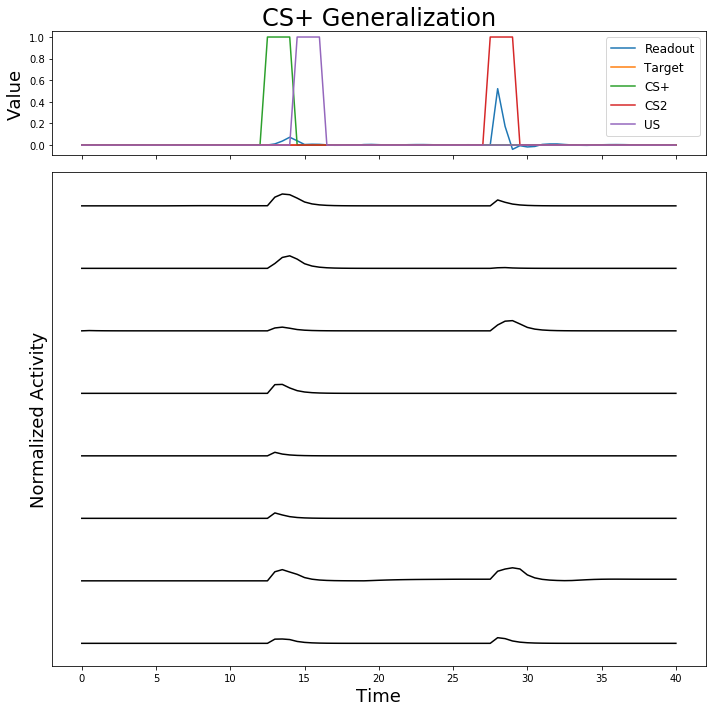

In [42]:
# Plot some results to compare to Fig 2A/B in paper
if not train_bool:
#     classic_net.load_state_dict(torch.load('trained_N5_no_plasticity_10odor_2000epochs.pt'))
#     classic_net.load_state_dict(torch.load('trained_N6_no_plasticity_1odor_2000epochs.pt'))
    classic_net.eval()

print_trial(classic_net, task='CS+', n_odors=n_od)
print_trial(classic_net, task='CS2', n_odors=n_od)
